

1. Preprocessing:
   - Ensure that all missing values in the dataset are properly handled (imputation or removal).
   - Align all time series datasets to a consistent time index.
   - Normalize the timestamp column across all datasets for consistent merging.
   
2. Exploratory Data Analysis (EDA):
   - Plot each time series to visually analyze the trends and patterns.
   - Analyze seasonality, trend components, and outliers.

3. Stationarity Tests:
   - Apply the Augmented Dickey-Fuller (ADF) test to check for stationarity.
   - Use the KPSS test as an alternative to confirm stationarity or detect trends.
   - Perform any necessary differencing or transformations to achieve stationarity.

4. SARIMA and VAR Modeling:
   - Apply SARIMA on univariate time series.
   - Apply VAR to handle multivariate time series forecasting.
   - Combine SARIMA and VAR models for an ensemble approach (if required).

5. Train PAC and LSTM Models:
   - Preprocess data for both Passive-Aggressive Classifier (PAC) and Long Short-Term Memory (LSTM) models.
   - Train the models with properly preprocessed data.
   - Evaluate model performance and make necessary adjustments.


In [21]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re

In [55]:
!pip install imbalanced-learn


In [1]:
import pandas as pd

# Load each dataset
fpl_df = pd.read_csv("FPL_tweets.csv")
synthetic_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin-1')
sentiment140_df = pd.read_csv("/content/twitter_sentiment_dataset.csv", encoding='latin-1')  # common encoding for that one
stock_df = pd.read_csv("/content/stock_tweets.csv")
mvsa_df = pd.read_csv("/content/stock_yfinance_data.csv")
daniel_df = pd.read_csv("/content/disasters.csv")

# Display shapes as a sanity check
print("FPL Tweets:", fpl_df.shape)
print("Synthetic Sentiment:", synthetic_df.shape)
print("Sentiment140:", sentiment140_df.shape)
print("Stock Tweets:", stock_df.shape)
print("MVSA Dataset:", mvsa_df.shape)
print("Daniel Dataset:", daniel_df.shape)


FPL Tweets: (114466, 13)
Synthetic Sentiment: (1599999, 6)
Sentiment140: (2000, 8)
Stock Tweets: (80793, 4)
MVSA Dataset: (6300, 8)
Daniel Dataset: (4913, 17)


In [2]:
# Load datasets
fpl_df = pd.read_csv("FPL_tweets.csv")
synthetic_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
sentiment140_df = pd.read_csv("/content/twitter_sentiment_dataset.csv")
stock_df = pd.read_csv("/content/stock_tweets.csv")
mvsa_df = pd.read_csv("/content/stock_yfinance_data.csv")
daniel_df = pd.read_csv("/content/disasters.csv")


In [3]:
import pandas as pd

# 1. FPL Tweets Dataset
fpl_df = pd.read_csv("/content/FPL_tweets.csv")
print("FPL Columns:", fpl_df.columns)  # Check column names in FPL
fpl_df['timestamp'] = pd.to_datetime(fpl_df['Timestamp'])
fpl_df['sentiment'] = 'neutral'  # Since no sentiment data, assigning neutral sentiment
fpl_df = fpl_df[['timestamp', 'Text', 'sentiment']]

# 2. Synthetic Sentiment Dataset
synthetic_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin-1')
print("Synthetic Columns:", synthetic_df.columns)  # Check column names in Synthetic Sentiment
synthetic_df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
synthetic_df['date'] = synthetic_df['date'].str.replace(r'\s[PDT|EST|GMT]+\s', '', regex=True)  # Remove timezone information
synthetic_df['timestamp'] = pd.to_datetime(synthetic_df['date'], errors='coerce')  # Convert date to datetime, coerce errors
synthetic_df['sentiment'] = synthetic_df['target'].map({0: 'negative', 4: 'positive'})
synthetic_df = synthetic_df[['timestamp', 'text', 'sentiment']]

# 3. Sentiment140 Dataset
sentiment140_df = pd.read_csv("/content/twitter_sentiment_dataset.csv", encoding='latin-1')
print("Sentiment140 Columns:", sentiment140_df.columns)  # Check column names in Sentiment140
sentiment140_df = sentiment140_df.rename(columns={'Tweet Text': 'text', 'Timestamp': 'timestamp', 'Sentiment': 'sentiment'})
sentiment140_df['sentiment'] = sentiment140_df['sentiment'].map({0: 'negative', 1: 'positive'})
sentiment140_df = sentiment140_df[['timestamp', 'text', 'sentiment']]

# 4. Stock Tweets Dataset
stock_df = pd.read_csv("/content/stock_tweets.csv")
print("Stock Tweets Columns:", stock_df.columns)  # Check column names in Stock Tweets
stock_df['timestamp'] = pd.to_datetime(stock_df['Date'])  # 'Date' is the column name for timestamp
stock_df['sentiment'] = 'neutral'  # Assuming neutral if sentiment is not provided
stock_df = stock_df[['timestamp', 'Tweet', 'sentiment']]

# 5. MVSA Dataset
mvsa_df = pd.read_csv("/content/stock_yfinance_data.csv", encoding='latin-1')
print("MVSA Columns:", mvsa_df.columns)  # Check column names in MVSA
mvsa_df['sentiment'] = 'neutral'  # Default neutral sentiment for stock data
mvsa_df = mvsa_df.rename(columns={'Date': 'timestamp', 'Stock Name': 'text'})  # Renaming for consistency
mvsa_df = mvsa_df[['timestamp', 'text', 'sentiment']]

# 6. Daniel Dataset
daniel_df = pd.read_csv("/content/disasters.csv", encoding='latin-1')
print("Daniel Dataset Columns:", daniel_df.columns)  # Check column names in Daniel Dataset
daniel_df = daniel_df.rename(columns={'start_date': 'timestamp', 'Disaster Subtype': 'text', 'Total Deaths': 'sentiment'})
daniel_df['sentiment'] = daniel_df['sentiment'].apply(lambda x: 'negative' if x > 0 else 'neutral')  # Map deaths to sentiment
daniel_df = daniel_df[['timestamp', 'text', 'sentiment']]

# Output: Check if data has been cleaned correctly
print(f"FPL Tweets: {fpl_df.shape}")
print(f"Synthetic Sentiment: {synthetic_df.shape}")
print(f"Sentiment140: {sentiment140_df.shape}")
print(f"Stock Tweets: {stock_df.shape}")
print(f"MVSA Dataset: {mvsa_df.shape}")
print(f"Daniel Dataset: {daniel_df.shape}")


FPL Columns: Index(['ID', 'Timestamp', 'User', 'Text', 'Hashtag', 'Retweets', 'Likes',
       'Replies', 'Source', 'Location', 'Verified_Account', 'Followers',
       'Following'],
      dtype='object')
Synthetic Columns: Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')


<ipython-input-3-5086021e163b>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  synthetic_df['timestamp'] = pd.to_datetime(synthetic_df['date'], errors='coerce')  # Convert date to datetime, coerce errors


Sentiment140 Columns: Index(['Tweet ID', 'Username', 'Tweet Text', 'Retweets', 'Favorites',
       'Followers', 'Timestamp', 'Sentiment'],
      dtype='object')
Stock Tweets Columns: Index(['Date', 'Tweet', 'Stock Name', 'Company Name'], dtype='object')
MVSA Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name'],
      dtype='object')
Daniel Dataset Columns: Index(['Disaster Type', 'Disaster Subtype', 'Disaster Group',
       'Disaster Subgroup', 'Event Name', 'Origin', 'Country', 'Location',
       'Latitude', 'Longitude', 'start_date', 'end_date', 'Total Deaths',
       'No Affected', 'Reconstruction Costs ('000 US$)',
       'Total Damages ('000 US$)', 'CPI'],
      dtype='object')
FPL Tweets: (114466, 3)
Synthetic Sentiment: (1599999, 3)
Sentiment140: (2000, 3)
Stock Tweets: (80793, 3)
MVSA Dataset: (6300, 3)
Daniel Dataset: (4913, 3)


In [4]:
pip install tweepy


In [5]:
pip install requests pandas


In [6]:
import requests
import pandas as pd
from datetime import datetime


In [7]:
import tweepy
import pandas as pd

# Replace this with your actual Bearer Token from Twitter Developer Portal
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAJ060wEAAAAAClvo3gj%2FWUiWwMdbweSeCy6Nj0s%3DqnORLbJeh234TpKWppefA1G7dZJ2W35H7fHvAJScwx6JFEdmEH"

# Initialize Twitter API client using tweepy
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Define the search query (customize as needed)
query = "AI OR artificial intelligence -is:retweet lang:en"

# Fetch 20 recent tweets
response = client.search_recent_tweets(
    query=query,
    tweet_fields=['created_at', 'author_id', 'public_metrics', 'text', 'lang', 'source'],
    user_fields=['username', 'location', 'verified', 'public_metrics'],
    expansions='author_id',
    max_results=20
)

# Parse tweets
tweets = response.data
users = {user.id: user for user in response.includes['users']}

# Format tweets into list of dicts
tweet_data = []
for tweet in tweets:
    user = users[tweet.author_id]
    metrics = tweet.public_metrics
    user_metrics = user.public_metrics
    tweet_data.append({
        "Timestamp": tweet.created_at,
        "Username": user.username,
        "Text": tweet.text,
        "Retweets": metrics['retweet_count'],
        "Likes": metrics['like_count'],
        "Replies": metrics['reply_count'],
        "Quote Count": metrics['quote_count'],
        "Followers": user_metrics['followers_count'],
        "Following": user_metrics['following_count'],
        "Location": user.location if user.location else "N/A",
        "Verified": user.verified,
        "Source": tweet.source
    })

# Convert to DataFrame
df = pd.DataFrame(tweet_data)

# Save to CSV
df.to_csv("twitter_data_one_time.csv", index=False)

print(" Successfully saved 20 tweets to 'twitter_data_one_time.csv'")


 Successfully saved 20 tweets to 'twitter_data_one_time.csv'


In [11]:
import os
import pandas as pd

# Check if the Twitter data file exists and is not empty
file_path = '/content/twitter_data_one_time.csv'

if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    twitter_df = pd.read_csv(file_path)
    print("Twitter Data Columns:", twitter_df.columns)

    # Select and rename columns
    twitter_df = twitter_df[['Timestamp', 'Text']]  # Only keep necessary columns
    twitter_df.columns = ['timestamp', 'text']
    twitter_df['sentiment'] = 'neutral'  # Placeholder sentiment
else:
    twitter_df = pd.DataFrame(columns=['timestamp', 'text', 'sentiment'])

# Standardize column names across all datasets
def standardize_columns(df):
    # Find the text column
    possible_text_cols = ['Text', 'text', 'Tweet', 'content']
    possible_time_cols = ['Timestamp', 'timestamp', 'date']

    text_col = next((col for col in possible_text_cols if col in df.columns), None)
    time_col = next((col for col in possible_time_cols if col in df.columns), None)

    if not text_col or not time_col:
        raise KeyError(f"Missing required columns. Found columns: {df.columns.tolist()}")

    df = df.rename(columns={text_col: 'text', time_col: 'timestamp'})

    if 'sentiment' not in df.columns:
        df['sentiment'] = 'neutral'

    return df[['timestamp', 'text', 'sentiment']]

fpl_df = standardize_columns(fpl_df)
synthetic_df = standardize_columns(synthetic_df)
sentiment140_df = standardize_columns(sentiment140_df)
stock_df = standardize_columns(stock_df)
mvsa_df = standardize_columns(mvsa_df)
daniel_df = standardize_columns(daniel_df)
twitter_df = standardize_columns(twitter_df)

# Merge all datasets
all_data = pd.concat(
    [fpl_df, synthetic_df, sentiment140_df, stock_df, mvsa_df, daniel_df, twitter_df],
    ignore_index=True
)

# Final cleaning
all_data = all_data.drop_duplicates()
all_data = all_data.reset_index(drop=True)

# Save to CSV
print("Final Merged Dataset Shape:", all_data.shape)
print(all_data.head())
all_data.to_csv('/content/merged_social_media_data.csv', index=False)


Twitter Data Columns: Index(['Timestamp', 'Username', 'Text', 'Retweets', 'Likes', 'Replies',
       'Quote Count', 'Followers', 'Following', 'Location', 'Verified',
       'Source'],
      dtype='object')
Final Merged Dataset Shape: (1775238, 3)
                   timestamp  \
0  2012-12-30 23:56:11+00:00   
1  2012-12-30 23:31:55+00:00   
2  2012-12-30 23:24:56+00:00   
3  2012-12-30 23:23:26+00:00   
4  2012-12-30 23:20:13+00:00   

                                                text sentiment  
0  I scored 75 points in Gameweek 20 on Fantasy P...   neutral  
1  110,525 have transferred Walcott into fantasy ...   neutral  
2  I scored 61 points in Gameweek 20 on Fantasy P...   neutral  
3  I scored 71 points in Gameweek 20 on Fantasy P...   neutral  
4  My life's ambition is to one week be the highe...   neutral  


In [17]:
import pandas as pd

# Load your JSON file
fake_df = pd.read_json('/content/fake_ai_sentiment_tweets.json')

# Rename the columns to match the main dataset
fake_df = fake_df.rename(columns={'date': 'timestamp', 'content': 'text'})

# Keep only the needed columns (drop 'id' if not needed)
fake_df = fake_df[['timestamp', 'text', 'sentiment']]

# Optional: Check the output
print(fake_df.head())


            timestamp                                               text  \
0 2023-04-17 22:57:00      AI is replacing artists, not empowering them.   
1 2023-06-01 15:03:00  These AI surveillance tools are such a privacy...   
2 2023-07-11 23:25:00  AI is helping us understand climate change bet...   
3 2023-04-17 23:13:00  Loving how AI assists in daily tasks—total pro...   
4 2023-11-26 20:12:00  AI-based diagnostics are saving lives in real ...   

  sentiment  
0  negative  
1  negative  
2  positive  
3  positive  
4  positive  


In [18]:
all_data = pd.concat([all_data, fake_df], ignore_index=True)
all_data = all_data.drop_duplicates().reset_index(drop=True)


In [19]:
# Merge the fake sentiment dataset with the main dataset
all_data = pd.concat([all_data, fake_df], ignore_index=True)

# Drop duplicates just in case and reset index
all_data = all_data.drop_duplicates().reset_index(drop=True)

# Save the updated merged dataset
all_data.to_csv('/content/merged_social_media_data_with_fake_sentiment.csv', index=False)

# Confirm shape and sample
print("Updated Merged Dataset Shape:", all_data.shape)
print(all_data['sentiment'].value_counts())
print(all_data.head())


Updated Merged Dataset Shape: (1775487, 3)
sentiment
positive    793622
negative    793293
neutral     186572
Name: count, dtype: int64
                   timestamp  \
0  2012-12-30 23:56:11+00:00   
1  2012-12-30 23:31:55+00:00   
2  2012-12-30 23:24:56+00:00   
3  2012-12-30 23:23:26+00:00   
4  2012-12-30 23:20:13+00:00   

                                                text sentiment  
0  I scored 75 points in Gameweek 20 on Fantasy P...   neutral  
1  110,525 have transferred Walcott into fantasy ...   neutral  
2  I scored 61 points in Gameweek 20 on Fantasy P...   neutral  
3  I scored 71 points in Gameweek 20 on Fantasy P...   neutral  
4  My life's ambition is to one week be the highe...   neutral  


In [44]:
import pandas as pd

# Load the merged dataset with fake sentiment
merged_data_path = "/content/merged_social_media_data_with_fake_sentiment.csv"
merged_df = pd.read_csv(merged_data_path)

# Check the first few rows to ensure it's loaded correctly
print(merged_df.head())
print(merged_df.info())


                   timestamp  \
0  2012-12-30 23:56:11+00:00   
1  2012-12-30 23:31:55+00:00   
2  2012-12-30 23:24:56+00:00   
3  2012-12-30 23:23:26+00:00   
4  2012-12-30 23:20:13+00:00   

                                                text sentiment  
0  I scored 75 points in Gameweek 20 on Fantasy P...   neutral  
1  110,525 have transferred Walcott into fantasy ...   neutral  
2  I scored 61 points in Gameweek 20 on Fantasy P...   neutral  
3  I scored 71 points in Gameweek 20 on Fantasy P...   neutral  
4  My life's ambition is to one week be the highe...   neutral  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775487 entries, 0 to 1775486
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  object
 1   text       object
 2   sentiment  object
dtypes: object(3)
memory usage: 40.6+ MB
None


<ipython-input-44-5ed9c808d792>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(merged_data_path)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from collections import Counter

# Load the dataset
df = pd.read_csv("/content/merged_social_media_data_with_fake_sentiment.csv")

# Drop rows with missing sentiment or text
df = df.dropna(subset=['text', 'sentiment'])

# Display original distribution
print("Original Sentiment Distribution:\n", df['sentiment'].value_counts())

# -----------------------------------
# TF-IDF Vectorization for SMOTE
# -----------------------------------
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text']).toarray()
y = df['sentiment']

# -----------------------------------
# Oversampling using SMOTE
# -----------------------------------
# SMOTE only works for numeric features, hence the TF-IDF step above
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a DataFrame with resampled features and labels
df_oversampled = pd.DataFrame(X_resampled, columns=tfidf.get_feature_names_out())
df_oversampled['sentiment'] = y_resampled

print("\nSentiment Distribution After SMOTE Oversampling:\n", Counter(y_resampled))

# -----------------------------------
# Undersampling 'neutral' class
# -----------------------------------
# Original DataFrame, not TF-IDF-based
df_majority = df[df['sentiment'] == 'neutral']
df_minority_pos = df[df['sentiment'] == 'positive']
df_minority_neg = df[df['sentiment'] == 'negative']

# Choose target size for balance (max of minority classes)
target_size = max(len(df_minority_pos), len(df_minority_neg))

# Downsample 'neutral' class
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=target_size,
                                   random_state=42)

# Combine all into one balanced DataFrame
df_undersampled = pd.concat([df_majority_downsampled, df_minority_pos, df_minority_neg])

print("\nSentiment Distribution After Undersampling:\n", df_undersampled['sentiment'].value_counts())

# -----------------------------------
# Optional: Save datasets
# -----------------------------------
df_oversampled.to_csv("/content/oversampled_sentiment_data.csv", index=False)
df_undersampled.to_csv("/content/undersampled_sentiment_data.csv", index=False)


<ipython-input-1-2ccb78a59cf0>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/merged_social_media_data_with_fake_sentiment.csv")


Original Sentiment Distribution:
 sentiment
positive    793622
negative    792863
neutral     186405
Name: count, dtype: int64


In [28]:
##
import nltk
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [30]:
import nltk
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Download the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    if isinstance(text, str):  # Ensure the text is a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
        tokens = word_tokenize(text)  # Tokenize the text
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
        return ' '.join(tokens)  # Rejoin tokens back to text
    else:
        return ''  # Return an empty string for NaN or non-string values

# Apply preprocessing to the text column
all_data['text'] = all_data['text'].apply(preprocess_text)

# Check the result
print(all_data.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                   timestamp  \
0  2012-12-30 23:56:11+00:00   
1  2012-12-30 23:31:55+00:00   
2  2012-12-30 23:24:56+00:00   
3  2012-12-30 23:23:26+00:00   
4  2012-12-30 23:20:13+00:00   

                                                text sentiment  
0  scored point gameweek fantasy premier league h...   neutral  
1  transferred walcott fantasy premier league sho...   neutral  
2  scored point gameweek fantasy premier league h...   neutral  
3  scored point gameweek fantasy premier league h...   neutral  
4  life ambition one week highest scorer fantasy ...   neutral  


In [32]:
##label encoding for sentiment

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the sentiment column
all_data['sentiment_encoded'] = label_encoder.fit_transform(all_data['sentiment'])

# Check the result
print(all_data[['sentiment', 'sentiment_encoded']].head())


  sentiment  sentiment_encoded
0   neutral                  1
1   neutral                  1
2   neutral                  1
3   neutral                  1
4   neutral                  1


In [33]:
print(all_data['sentiment'].unique())


['neutral' 'negative' 'positive' nan]


In [48]:
import pandas as pd

# Step 1: Load the merged dataset and force 'timestamp' column to datetime on import
merged_data = pd.read_csv("/content/merged_social_media_data_with_fake_sentiment.csv",
                          parse_dates=['timestamp'],
                          dtype={'timestamp': str},  # Ensure 'timestamp' is initially treated as string
                          low_memory=False)  # Prevents warning for mixed data types in large files

# Step 2: Handle missing values
def handle_missing_values(df, text_column='text', timestamp_column='timestamp'):
    # For text column, replace NaN values with a placeholder or empty string
    df[text_column] = df[text_column].fillna("No data")  # Replace with a placeholder if needed

    # For timestamp column, remove rows with NaT or missing timestamp
    df = df.dropna(subset=[timestamp_column])

    return df

# Apply missing value handling to the merged dataset
merged_data = handle_missing_values(merged_data)

# Step 3: Align all time series to a consistent time index
def align_time_series(df, timestamp_column='timestamp'):
    # Ensure the timestamp column is in datetime format
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce', utc=True)

    # Drop rows where timestamp is NaT (after coercion, invalid timestamps become NaT)
    df = df.dropna(subset=[timestamp_column])

    # Set timestamp as index
    df.set_index(timestamp_column, inplace=True)

    return df

# Apply time alignment to the merged dataset
merged_data = align_time_series(merged_data)

# Step 4: Normalize the timestamp across all datasets
def normalize_timestamp(df, timestamp_column='timestamp', freq='D'):
    # First, separate out numeric and non-numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Resample numeric columns to a consistent frequency (daily, hourly, etc.)
    df_resampled = df[numeric_cols].resample(freq).mean()  # Mean aggregation for numeric columns

    # Ensure the text columns (or other non-numeric columns) are preserved correctly
    # Here, we'll take the first text entry for each resample group
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns
    df_non_numeric = df[non_numeric_cols].resample(freq).first()  # You can change aggregation as needed

    # Combine the resampled numeric and non-numeric data
    df_combined = pd.concat([df_resampled, df_non_numeric], axis=1)

    return df_combined

# Apply timestamp normalization (assuming daily frequency)
merged_data = normalize_timestamp(merged_data)

# Check the result
print(merged_data.head())


                                                                        text  \
timestamp                                                                      
2012-10-29 00:00:00+00:00  I scored 45 points in Gameweek 9 on Fantasy Pr...   
2012-10-30 00:00:00+00:00  Fantasy premier league gossip group @Jiansen96...   
2012-10-31 00:00:00+00:00  @timotiusmarlon4 @Ardhakadabra udeh join deh d...   
2012-11-01 00:00:00+00:00  fantasy premier league . tinggi jugk point aku...   
2012-11-02 00:00:00+00:00  Premier League Fantasy Football Blog: Looking ...   

                          sentiment  
timestamp                            
2012-10-29 00:00:00+00:00   neutral  
2012-10-30 00:00:00+00:00   neutral  
2012-10-31 00:00:00+00:00   neutral  
2012-11-01 00:00:00+00:00   neutral  
2012-11-02 00:00:00+00:00   neutral  


In [51]:
# Check the column names in the DataFrame
print(merged_data.columns)


Index(['text', 'sentiment', 'tweet_length'], dtype='object')


In [52]:
# Adding a fake timestamp column if you want to simulate time-based analysis
import pandas as pd
import numpy as np

# Generating a fake timestamp (for example, using a daily frequency)
merged_data['timestamp'] = pd.date_range(start='2022-01-01', periods=len(merged_data), freq='D')

# Check the updated DataFrame
print(merged_data.head())


                                                                        text  \
timestamp                                                                      
2012-10-29 00:00:00+00:00  I scored 45 points in Gameweek 9 on Fantasy Pr...   
2012-10-30 00:00:00+00:00  Fantasy premier league gossip group @Jiansen96...   
2012-10-31 00:00:00+00:00  @timotiusmarlon4 @Ardhakadabra udeh join deh d...   
2012-11-01 00:00:00+00:00  fantasy premier league . tinggi jugk point aku...   
2012-11-02 00:00:00+00:00  Premier League Fantasy Football Blog: Looking ...   

                          sentiment  tweet_length  timestamp  
timestamp                                                     
2012-10-29 00:00:00+00:00   neutral            79 2022-01-01  
2012-10-30 00:00:00+00:00   neutral            90 2022-01-02  
2012-10-31 00:00:00+00:00   neutral           101 2022-01-03  
2012-11-01 00:00:00+00:00   neutral            81 2022-01-04  
2012-11-02 00:00:00+00:00   neutral           113 2022-01-05 

In [53]:
##=====EDA=====##
import plotly.express as px
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter


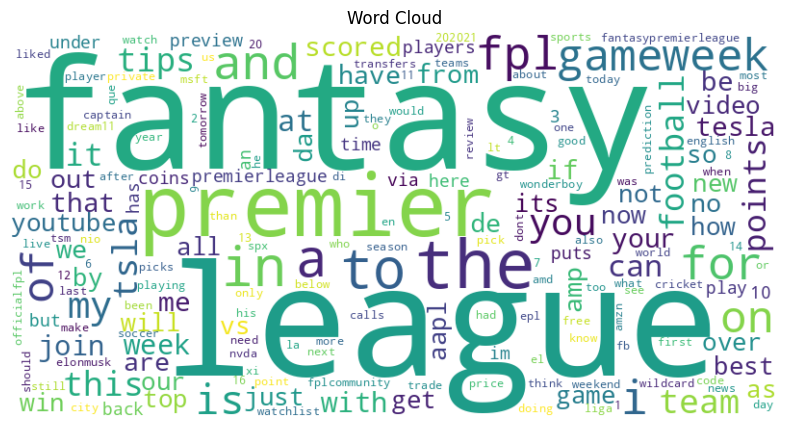

In [54]:

# 1. Sentiment Distribution
sentiment_dist = merged_data['sentiment'].value_counts().reset_index()
sentiment_dist.columns = ['Sentiment', 'Count']

fig_sentiment = px.bar(sentiment_dist, x='Sentiment', y='Count', color='Sentiment',
                       title="Sentiment Distribution", labels={'Count': 'Number of Tweets'})
fig_sentiment.show()

# 2. Word Frequency Analysis
# Cleaning and tokenizing the text data
all_text = " ".join(merged_data['text'].dropna())
all_text = re.sub(r"[^a-zA-Z0-9\s]", "", all_text.lower())
word_list = all_text.split()

# Counting the frequency of words
word_freq = Counter(word_list)
common_words = word_freq.most_common(20)  # Top 20 frequent words
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

fig_word_freq = px.bar(word_freq_df, x='Word', y='Frequency', title="Top 20 Words Frequency", labels={'Frequency': 'Count'})
fig_word_freq.show()

# 3. Word Cloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

# 4. Hashtag Analysis
# Extracting hashtags from the text
hashtags = []
for text in merged_data['text'].dropna():
    hashtags.extend(re.findall(r'#\w+', text))

hashtag_freq = Counter(hashtags)
common_hashtags = hashtag_freq.most_common(20)  # Top 20 most common hashtags
hashtag_freq_df = pd.DataFrame(common_hashtags, columns=['Hashtag', 'Frequency'])

fig_hashtags = px.bar(hashtag_freq_df, x='Hashtag', y='Frequency', title="Top 20 Hashtags", labels={'Frequency': 'Count'})
fig_hashtags.show()

# 5. Tweet Length Insights
merged_data['tweet_length'] = merged_data['text'].apply(lambda x: len(str(x)))

fig_length = px.histogram(merged_data, x='tweet_length', nbins=50, title="Distribution of Tweet Lengths", labels={'tweet_length': 'Length of Tweet'})
fig_length.show()

# 6. Trend Analysis Over Time
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# Resampling the data by day for trend analysis
daily_trend = merged_data.groupby(merged_data['timestamp'].dt.date).size().reset_index(name='Tweet Count')

fig_trend = px.line(daily_trend, x='timestamp', y='Tweet Count', title="Trend of Tweets Over Time", labels={'Tweet Count': 'Number of Tweets'})
fig_trend.show()


In [36]:
##=====Models=======##

In [38]:
##passiveagressive

In [37]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Convert text data to numerical representation using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize the Passive-Aggressive Classifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = pac.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Passive-Aggressive Model Accuracy: {accuracy:.4f}")


Passive-Aggressive Model Accuracy: 0.7666


In [40]:
##Convolutional Neural Network (CNN) for Text Classification
import tensorflow as tf  # Add this import for TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Prepare the data: Label encoding and text padding
max_words = 5000
max_len = 100

# Tokenize the text data
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
X_train_tokens = X_train.apply(lambda x: tokenizer.tokenize(x))
X_test_tokens = X_test.apply(lambda x: tokenizer.tokenize(x))

# Convert tokens to sequences (integer values)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 2 classes: positive and negative sentiment

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"CNN Model Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
22194/22194 ━━━━━━━━━━━━━━━━━━━━ 101s 4ms/step - accuracy: 0.1053 - loss: nan - val_accuracy: 0.1052 - val_loss: nan
Epoch 2/5
22194/22194 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.1049 - loss: nan - val_accuracy: 0.1052 - val_loss: nan
Epoch 3/5
22194/22194 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.1053 - loss: nan - val_accuracy: 0.1052 - val_loss: nan
Epoch 4/5
22194/22194 ━━━━━━━━━━━━━━━━━━━━ 150s 5ms/step - accuracy: 0.1051 - loss: nan - val_accuracy: 0.1052 - val_loss: nan
Epoch 5/5
22194/22194 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 0.1052 - loss: nan - val_accuracy: 0.1052 - val_loss: nan
11097/11097 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.1040 - loss: nan
CNN Model Accuracy: 0.1052
